# Feature Selection

This notebook compares features extracted from twitter threads against one another. For a look into the Twitter data itself, see the [Exploratory Data Analysis](./exploratory_data_analysis.ipynb)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lib.util import fetch_thread

In [18]:
def fetch_safe(event):
    data, y = fetch_thread(event)
    data.drop(["Adverb_mean", "Adverb_sum", "Adverb_var"], axis=1, inplace=True)
    return data

Z = fetch_safe("germanwings-crash")
Z.describe()

,has_coords_mean,has_coords_sum,has_coords_var,Pronoun_mean,Pronoun_sum,Pronoun_var,thread_length,hashtags_count_mean,hashtags_count_sum,hashtags_count_var,...,created,src.created_at,src.tweets_total,first_resp,last_resp,resp_var,component_count,largest_cc_diameter,time_to_first_resp,time_to_last_resp
count,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,...,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02,4.050000e+02
mean,3.884410e-16,6.195319e-17,4.931583e-16,-8.854371e-16,-2.324615e-16,-2.467162e-17,-7.894919e-17,-8.525416e-16,-1.096517e-18,-1.792805e-16,...,1.167455e-12,1.790474e-15,-9.375217e-17,4.124152e-13,-3.996101e-13,9.765851e-17,3.528042e-16,-3.772017e-16,-1.699601e-17,-1.112964e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.798284e-01,-4.729721e-01,-3.834338e-01,-1.043556e+00,-7.101398e-01,-8.115218e-01,-9.386605e-01,-8.730495e-01,-8.644195e-01,-4.582775e-01,...,-6.262043e-01,-1.351978e+00,-9.986559e-01,-6.394830e-01,-7.303974e-01,-2.341164e-01,-1.682398e+00,-1.096450e+00,-1.161921e-01,-4.846707e-01
25%,-3.798284e-01,-4.729721e-01,-3.834338e-01,-1.043556e+00,-7.101398e-01,-8.115218e-01,-7.283383e-01,-6.750161e-01,-5.894078e-01,-4.022313e-01,...,-5.972268e-01,-6.506988e-01,-7.932471e-01,-6.040732e-01,-6.726064e-01,-2.340749e-01,-5.136652e-01,-3.960364e-01,-1.129378e-01,-4.557384e-01
50%,-3.798284e-01,-4.729721e-01,-3.834338e-01,-1.824548e-01,-4.027036e-01,-3.124850e-01,-4.128548e-01,-2.506589e-01,-3.143961e-01,-2.481043e-01,...,-5.691532e-01,-2.159354e-01,-2.830801e-01,-5.656328e-01,-5.751977e-01,-2.326118e-01,-5.136652e-01,-3.960364e-01,-1.090147e-01,-3.903084e-01
75%,-3.798284e-01,-4.729721e-01,-3.834338e-01,6.473340e-01,2.121690e-01,3.454200e-01,6.387565e-01,2.161341e-01,2.356273e-01,-3.793119e-02,...,8.221633e-01,4.621539e-01,6.640220e-01,7.782767e-01,5.762397e-01,-2.099105e-01,6.550674e-01,3.043773e-01,-9.220795e-02,-4.945117e-02
max,6.363070e+00,5.608097e+00,6.703835e+00,3.606392e+00,5.438586e+00,4.981143e+00,6.948425e+00,5.662052e+00,6.010873e+00,1.005038e+01,...,2.537289e+00,2.571983e+00,6.646507e+00,3.898232e+00,4.613243e+00,9.886730e+00,6.498730e+00,5.907687e+00,1.898264e+01,8.028642e+00


## Univariate Feature Selection

### Pearson Correlation

For each potentially useful feature $X$, calculate the correlation coefficient between the values of that feature and response variable $Y$, which is 0 if this thread is non-rumor and 1 if rumor.

$$\rho = \frac{cov(X,Y)}{\sigma_X \sigma_Y}$$

* $cov$ is the covariance
* $\sigma_X$ is the standard deviation of feature X
* $\sigma_Y$ is the standard deviation of response variable Y

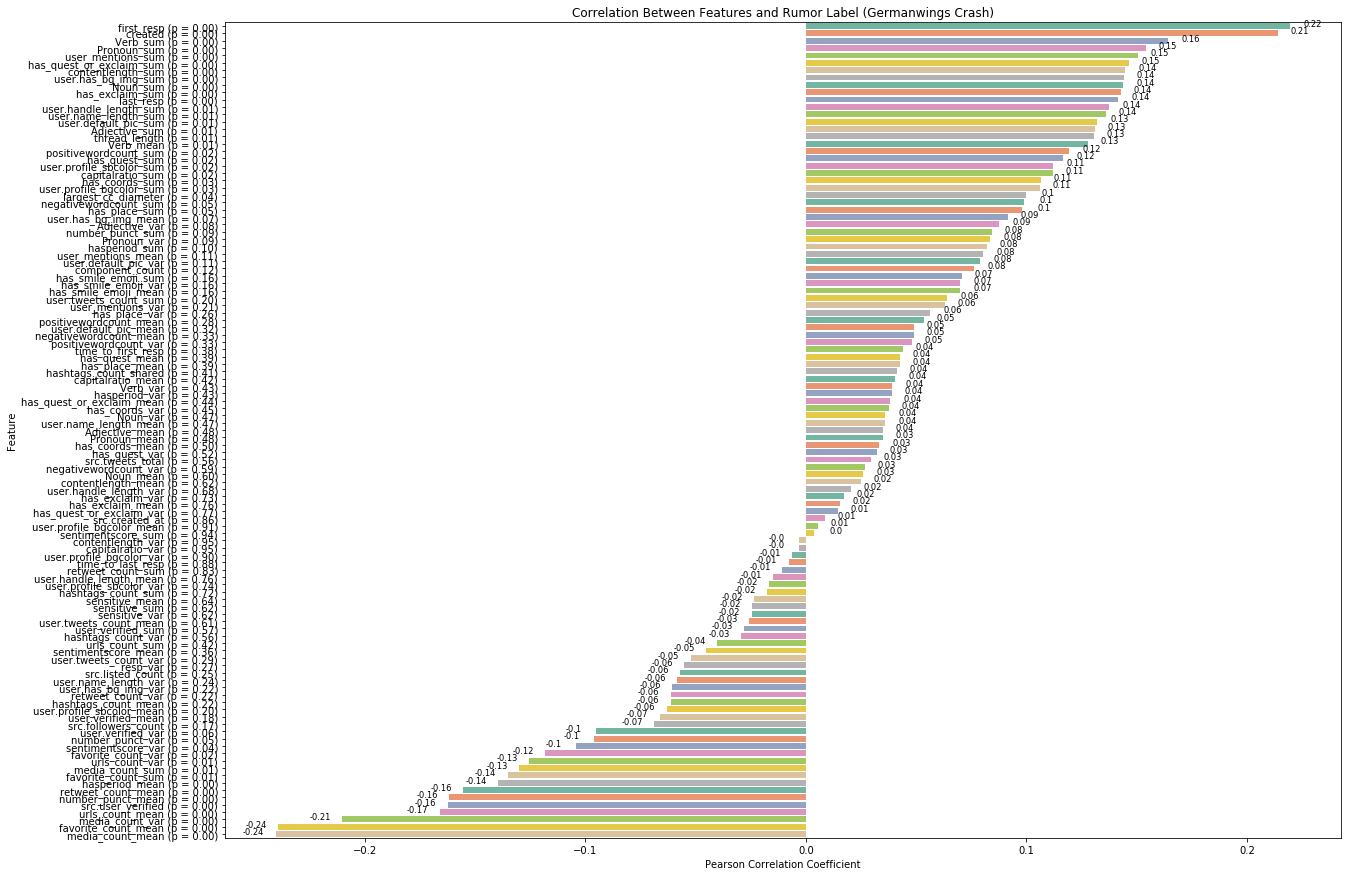

In [20]:
from scipy.stats import pearsonr

def plotCorr(data):
    corr = data.apply(lambda x: pearsonr(x, y), axis=0, result_type='expand')\
        .T \
        .rename(columns={0: "coef", 1: "pval"}) \
        .sort_values(by=["coef"], ascending=False)

    plt.figure(figsize=(20,15))
    plt.title("Correlation Between Features and Rumor Label (Germanwings Crash)")

    labels = [index + " (p = %.2f)" % round(row.pval, 2) for index, row in corr.iterrows()]
    ax = sns.barplot(y=labels, x=corr.coef, palette="Set2")
    ax.set(xlabel="Pearson Correlation Coefficient", ylabel="Feature")

    offset = 0.01
    i = 0
    for index, row in corr.iterrows():
        ax.text(row.coef + (offset if row.coef > 0 else -offset), i, round(row.coef, 2), 
                color="black",
                ha="center",
                fontsize='small')
        i += 1
        
plotCorr(Z)

The p-values for each feature rougly mean the probability of an uncorrelated system creating a correlation value of this magnitude by chance. By using Pearson correlation, we're assuming that there's a linear relationship between a particular feature $X$ and the classification response variable $Y$.

The results of this test seem to support what are intuitively relevant features in rumor classification.
* If the original tweet poster is verified, `src.user_verified` negatively correlates with being classified as fake news.
* Surprisingly the time of the first response, `first_resp`, has the strongest positive correlation of all the features for this dataset.

In [30]:
fetch_safe("ferguson").describe()

,favorite_count_mean,favorite_count_sum,favorite_count_var,has_quest_mean,has_quest_sum,has_quest_var,number_punct_mean,number_punct_sum,number_punct_var,Adjective_mean,...,created,src.created_at,src.tweets_total,first_resp,last_resp,resp_var,component_count,largest_cc_diameter,time_to_first_resp,time_to_last_resp
count,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,...,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03,1.010000e+03
mean,-1.834960e-16,-1.758769e-18,6.085616e-17,-3.709203e-15,-1.192665e-16,1.700506e-15,1.984524e-15,-5.935846e-17,-1.234766e-15,1.075680e-15,...,-2.138298e-13,1.618480e-15,-2.003348e-17,4.244460e-14,-1.528814e-13,-3.458180e-16,-4.178176e-16,4.056161e-17,-7.823500e-16,-1.670831e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.828330e-01,-2.124220e-01,-3.468594e-02,-1.231600e+00,-6.038755e-01,-1.506554e+00,-2.050812e+00,-8.218373e-01,-1.201413e+00,-2.207127e+00,...,-2.054762e+00,-1.999243e+00,-7.804320e-01,-2.065936e+00,-1.520073e+00,-2.066158e-01,-1.316496e+00,-1.337985e+00,-1.102203e-01,-4.520377e-01
25%,-1.277626e-01,-1.627079e-01,-3.454975e-02,-7.551457e-01,-4.660729e-01,-7.732193e-01,-6.973871e-01,-5.023193e-01,-6.558028e-01,-6.710759e-01,...,-4.065589e-01,-8.040636e-01,-5.609375e-01,-4.107245e-01,-4.278994e-01,-2.064660e-01,-6.585736e-01,-7.491549e-01,-1.102203e-01,-4.282487e-01
50%,-8.375118e-02,-1.196861e-01,-3.432943e-02,-9.725715e-02,-3.282703e-01,9.061028e-02,-1.723268e-01,-2.871337e-01,-2.362844e-01,-3.228753e-02,...,2.730473e-03,-3.093826e-01,-3.707995e-01,-1.045846e-03,6.281783e-02,-2.045618e-01,-6.514081e-04,-1.603250e-01,-1.102203e-01,-3.602788e-01
75%,2.980909e-03,-3.157110e-02,-3.358625e-02,5.111589e-01,8.513744e-02,7.402106e-01,4.463955e-01,1.090035e-01,3.063321e-01,6.185006e-01,...,8.581611e-01,6.691367e-01,2.234480e-01,8.571731e-01,2.123709e-01,-1.744689e-01,6.572708e-01,4.285049e-01,-1.102203e-01,-8.538568e-02
max,3.092959e+01,2.906408e+01,3.172940e+01,6.330687e+00,1.648365e+01,4.369599e+00,4.938228e+00,1.101337e+01,8.432015e+00,6.740784e+00,...,1.029488e+00,2.676393e+00,8.108874e+00,1.078551e+00,8.712436e+00,1.416953e+01,1.118403e+01,3.961484e+00,1.896498e+01,9.844849e+00


## Colinearity

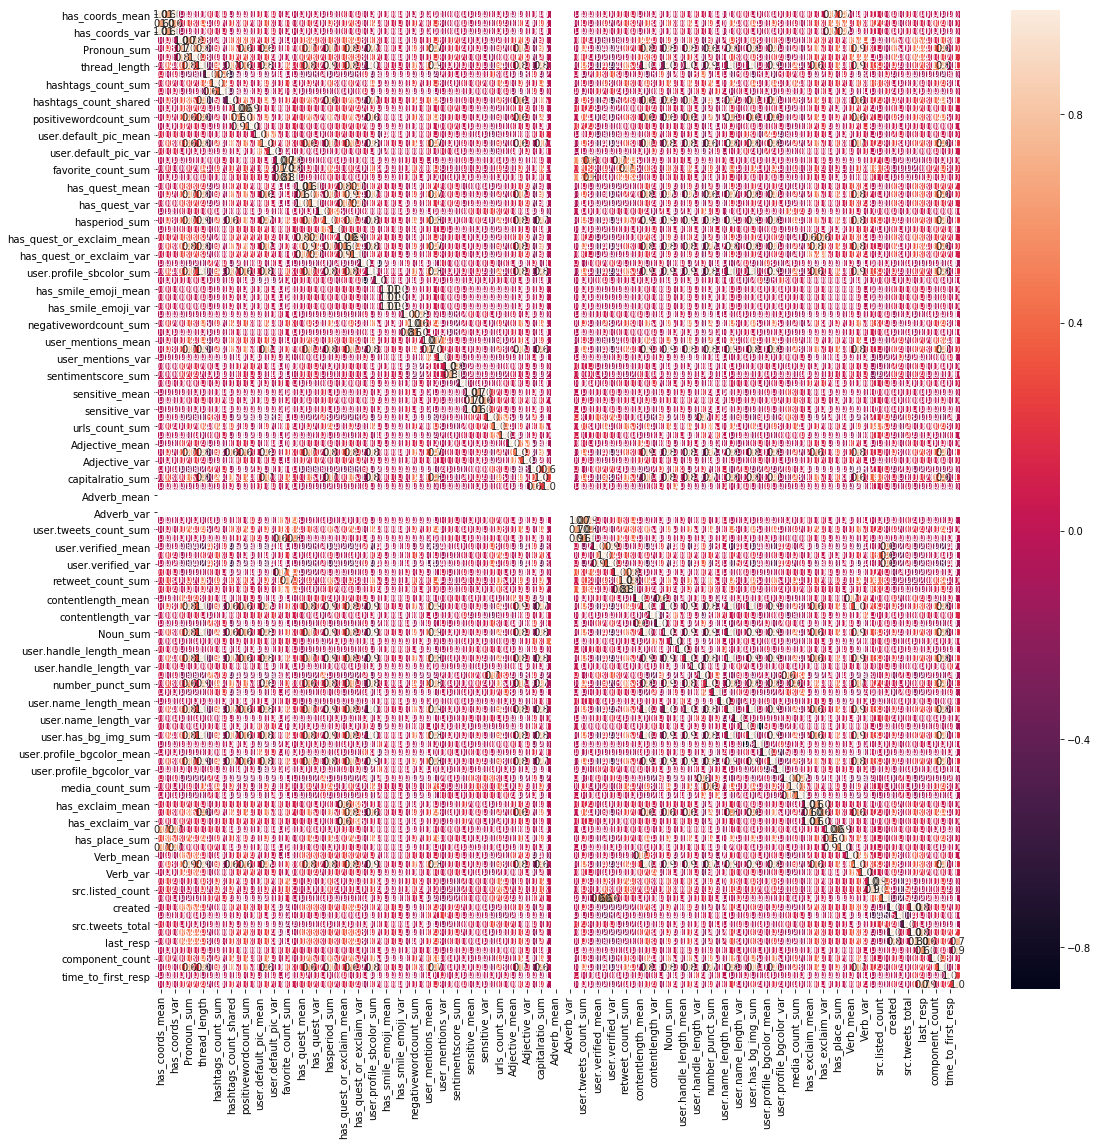

In [10]:
f, ax = plt.subplots(figsize=(18,18))
sns.heatmap(Z.corr(), annot=True, linewidth=0.5, fmt='.1f', ax=ax)